# Guild Wars 2 Achievement System Analysis

Guild Wars 2 is a Massively multiplayer online role-playing game created by ArenaNet, which tends to cater to a more casual players and focuses more on cooperative play with some single player campaign.

This project analyzes the game achievement systems in order to determine which achievement players should pursue according to their play style and time commitment to the game. This as done by looking at the rewards of each achievements and determining their importance based on their monetary value, the strength and the rarity of the items received.

Using supervised learning and clustering methods on the rewards given for completing achievements I predict the financial worth of each achievement in game. Specifically, I used the Linear Regression and Decision Trees Regression to create a model which will predict the importance of an achievement based on the vendor value of the reward players received from completing the achievement. I also used Forest Trees to classify those achievements according to categories, so it will be possible to predict the type of achievements which the players should pursue

In [1]:
import sklearn as sk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns

from scipy import io
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection, metrics, linear_model, datasets, feature_selection

# Cleaning The Data

To get the information I used the Guild Wars 2 API (found here: https://wiki.guildwars2.com/wiki/API:Main)
For the analysis I used the following data:

Achievement Category: which gave me the information about the type of achievement it is and was used to cluster the data

Achievement Points: the amount of points players receive from each achievement, collecting those point allow the players to collect better rewards in the future

Reward Type: the type of reward the player gets for completing the achievement

Item Type: the type of item the player gets as a reward

Rarity: the rarity of the item the player gets

Level of Reward: the level of the reward (80 is the max level in the game)

Vendor Value: the sell value (in coins) of the reward item

In [2]:
#import CSV

Achievements = pd.read_csv("clean Data/Achievement.csv")
Items = pd.read_csv("clean Data/ItemFin.csv")
Titles = pd.read_csv("clean Data/titles.csv")
Categories = pd.read_csv("clean Data/categories.csv")
Groups = pd.read_csv("clean Data/groups.csv")

In [3]:
def json_to_df(row, json_col, indexcol = None):
    if row[json_col] == 'nan':
        row[json_col] = '[]'
    else:
        row[json_col] = row[json_col].replace("'", "\"")
    json_df = pd.read_json(row[json_col])
    json_df[indexcol] = row[indexcol]
    dfs.append(json_df)

In [4]:
#first I want to marge the catagories and groups table
Groups_fin = Groups.drop(['id', 'description'], axis=1)

dfs = []
Categories['achievements'] = Categories['achievements'].astype(str)
Categories.apply(json_to_df, axis=1, json_col='achievements', indexcol = 'id')
Categorie_con = pd.concat(dfs)

Categories_fin = Categories.merge(Categorie_con, on=['id'])

Categories_final = Categories_fin.drop(['achievements'], axis=1).rename(index=str, columns={0: 'achievements', 'id':'categories'})

Achievement_Categories = pd.merge(Groups_fin, Categories_final, on='categories', how='inner').rename(index=str, columns={'name_x': 'Group_name', 'name_y':'categories_name'}).sort_values(['order_y','order_x'])
Achievement_Categories.head()

C:\Users\FluffyKitten\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  import sys


,Group_name,order_x,categories,categories_name,order_y,achievements
1822,Daily,1,97,Daily,0,2912.0
1823,Daily,1,97,Daily,0,1973.0
1824,Daily,1,97,Daily,0,3626.0
1825,Daily,1,97,Daily,0,1932.0
1826,Daily,1,97,Daily,0,1931.0


In [5]:
#next, merging the catagories with the achievements
Achievements_Value_fin = Achievements[['id','name','rewards','tiers']].rename(index=str, columns={"id": "achievements"})

dfs = []
Achievements_Value_fin['tiers'] = Achievements_Value_fin['tiers'].astype(str)
Achievements_Value_fin.apply(json_to_df, axis=1, json_col='tiers', indexcol = 'name')
Achievements_tire = pd.concat(dfs).rename(index=str, columns={"points": "AP_points"})

New_tires = Achievements_Value_fin.merge(Achievements_tire, on=['name'])
final_tires = New_tires.drop(['tiers'], axis=1)

dfs = []
Achievements_Value_fin['rewards'] = Achievements_Value_fin['rewards'].astype(str)
Achievements_Value_fin.apply(json_to_df, axis=1, json_col='rewards', indexcol = 'name')
Achievements_rew = pd.concat(dfs)

rewards = final_tires.merge(Achievements_rew, on=['name'])
Achievement_final = rewards.drop(['rewards','region'], axis=1).rename(index=str, columns={"id": "id_reward"}).fillna(0)

#making dummies for the Achievement type

Achievement_final['Type'] = Achievement_final.type.map({'Coins':0, 'Item':1, 'Mastery':2, 'Title':3})
Achievements_final = Achievement_final.drop(['type'], axis=1)
Achievements_final.head()

#making dummies for the Achievement type

#dropping the title rewards
Achievement = Achievements_final[Achievements_final.Type != 3]
Achievement.head()

C:\Users\FluffyKitten\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  from ipykernel import kernelapp as app


,achievements,name,count_x,AP_points,count_y,id_reward,Type
4,64,Crime and Punishment,1,10,0.0,208.0,2
5,65,Graduation Day,1,10,0.0,208.0,2
6,66,Rising to the Challenge,1,10,0.0,208.0,2
7,67,For the Legion!,1,10,0.0,208.0,2
8,68,Waking from the Nightmare,1,10,0.0,208.0,2


In [6]:
#merging the Achievements and the Categories
Achievements_sorted = Achievement_Categories.merge(Achievement, on=['achievements'])
Achievements_sorted.head()

,Group_name,order_x,categories,categories_name,order_y,achievements,name,count_x,AP_points,count_y,id_reward,Type
0,Daily,1,97,Daily,0,1973.0,Daily Maguuma Jungle Forager,4,0,1.0,68138.0,1
1,Daily,1,97,Daily,0,3626.0,Daily Crystal Oasis Bounty Hunter,1,0,1.0,83524.0,1
2,Daily,1,97,Daily,0,1932.0,Daily Orr Vista Viewer,1,0,1.0,68115.0,1
3,Daily,1,97,Daily,0,1931.0,Daily Maguuma Vista Viewer,1,0,1.0,68115.0,1
4,Daily,1,97,Daily,0,1953.0,Daily Wayfarer Foothills Event Completer,4,0,1.0,68149.0,1


In [7]:
#cleaning up and sorting the item list 
Items_Value = Items[['id','name','rarity','vendor_value', 'type', 'level']].rename(index=str, columns={"id": "id_reward"})

Items_Value['id_reward'] = Items_Value.id_reward.astype('int64')

Items_Value['How_rare'] = Items_Value.rarity.map({'Junk':0, 'Basic':1, 'Fine':2, 'Masterwork':3, 
                                                  'Rare':4, 'Exotic':5,'Ascended':6, 'Legendary':7})

Items_Value['Type'] = Items_Value.type.map({'Armor':0, 'Back':1, 'Bag':2, 'Consumable':3, 'Container':4, 
                                            'CraftingMaterial':5,'Gathering':6, 'Gizmo':7, 'MiniPet':8,
                                           'Tool':9,'Trait':10,'Trinket':11, 'Trophy':12, 
                                            'UpgradeComponent':13, 'Weapon':14})
Items_Value_fin = Items_Value.drop(['type','rarity'], axis=1)

Items_Value_fin.head()

,id_reward,name,vendor_value,level,How_rare,Type
0,24,Sealed Package of Snowballs,0,0,1,3.0
1,57,Hearty Back Brace,16,0,1,1.0
2,61,Rampagers Spineguard of Coral,132,80,3,1.0
3,68,Mighty Country Coat,6,0,1,0.0
4,69,Mighty Country Coat,7,0,1,0.0


In [8]:
Achievement_item_final = pd.merge(Achievements_sorted, Items_Value_fin, on='id_reward', how='inner')
Achievements_items_sorted = Achievement_item_final.fillna(value='0').rename(index=str, columns={"Type_x": "Item_Type","Type_y": 
                                                                                                "Reward_Type", 'count_y':'Item_Count',
                                                                                               'count_x':'Tier_Count','name_x':'achievement_name',
                                                                                               'name_y':'Item_name'})
Achievements_items_sorted.head()

,Group_name,order_x,categories,categories_name,order_y,achievements,achievement_name,Tier_Count,AP_points,Item_Count,id_reward,Item_Type,Item_name,vendor_value,level,How_rare,Reward_Type
0,Daily,1,97,Daily,0,1973.0,Daily Maguuma Jungle Forager,4,0,1.0,68138.0,1,Chest of Plants,0,0,4,4.0
1,Daily,1,97,Daily,0,3626.0,Daily Crystal Oasis Bounty Hunter,1,0,1.0,83524.0,1,Chest of the Desert Hero,0,0,4,4.0
2,Daily,1,97,Daily,0,1932.0,Daily Orr Vista Viewer,1,0,1.0,68115.0,1,Chest of the Hero,0,0,4,4.0
3,Daily,1,97,Daily,0,1931.0,Daily Maguuma Vista Viewer,1,0,1.0,68115.0,1,Chest of the Hero,0,0,4,4.0
4,Daily,1,97,Daily,0,1953.0,Daily Wayfarer Foothills Event Completer,4,0,1.0,68149.0,1,Chest of the Hero,0,0,5,4.0


In [9]:
#splitting the data
from sklearn.model_selection import train_test_split

X = Achievements_items_sorted[['How_rare','level','Reward_Type','Item_Type','AP_points']]
y = Achievements_items_sorted['vendor_value']


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state = 0)


In [10]:
from sklearn import preprocessing

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Linear Regression

In [11]:
from sklearn.linear_model import LinearRegression

LinearReg = LinearRegression()
LinearReg.fit(X_train, y_train)

score = LinearReg.score(X_train, y_train)
scoreTest=LinearReg.score(X_test, y_test)

print('training score:',score)
print('test score:',scoreTest)

predictionLog = LinearReg.predict(X_train)


training score: 0.5338639048093479
test score: 0.5541490855542637


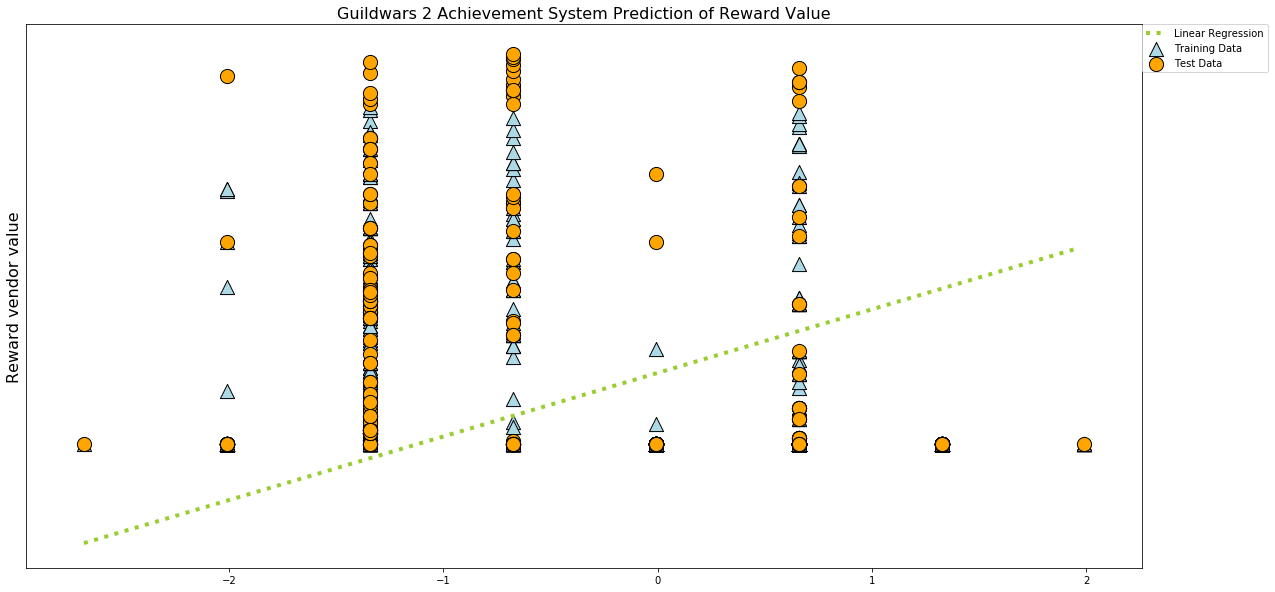

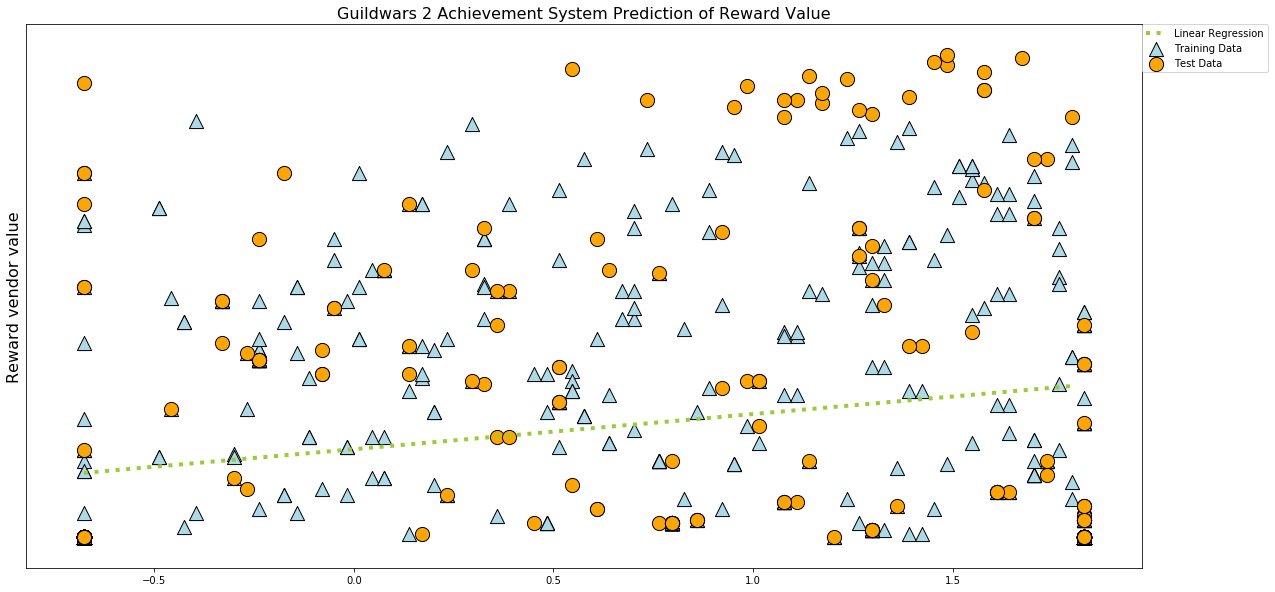

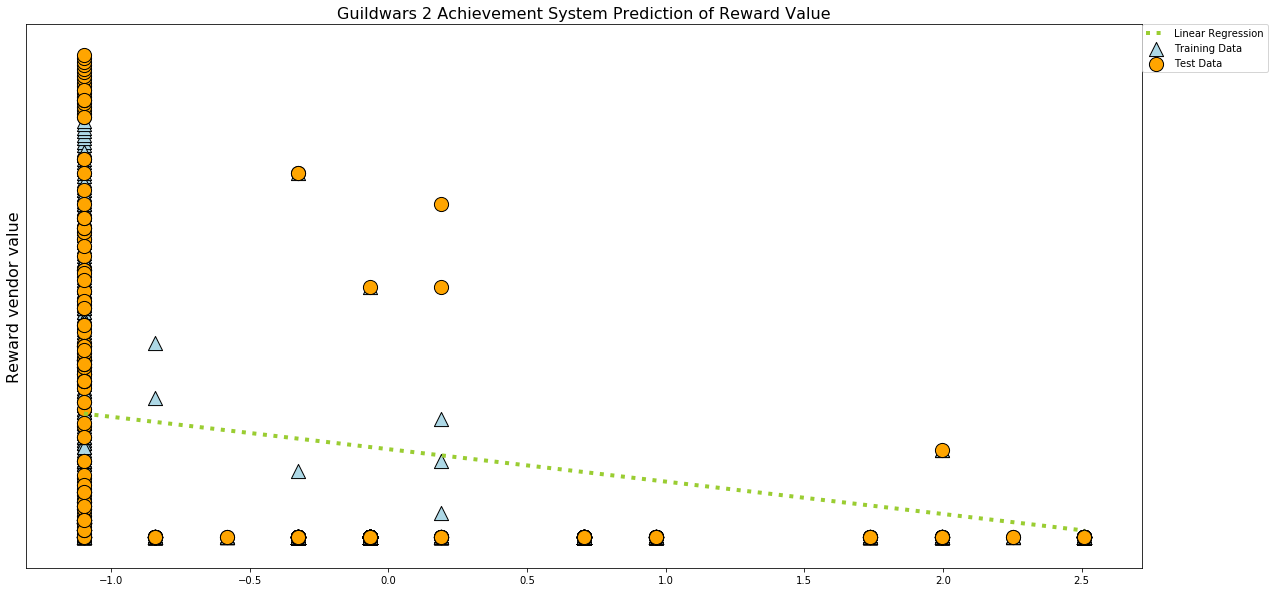

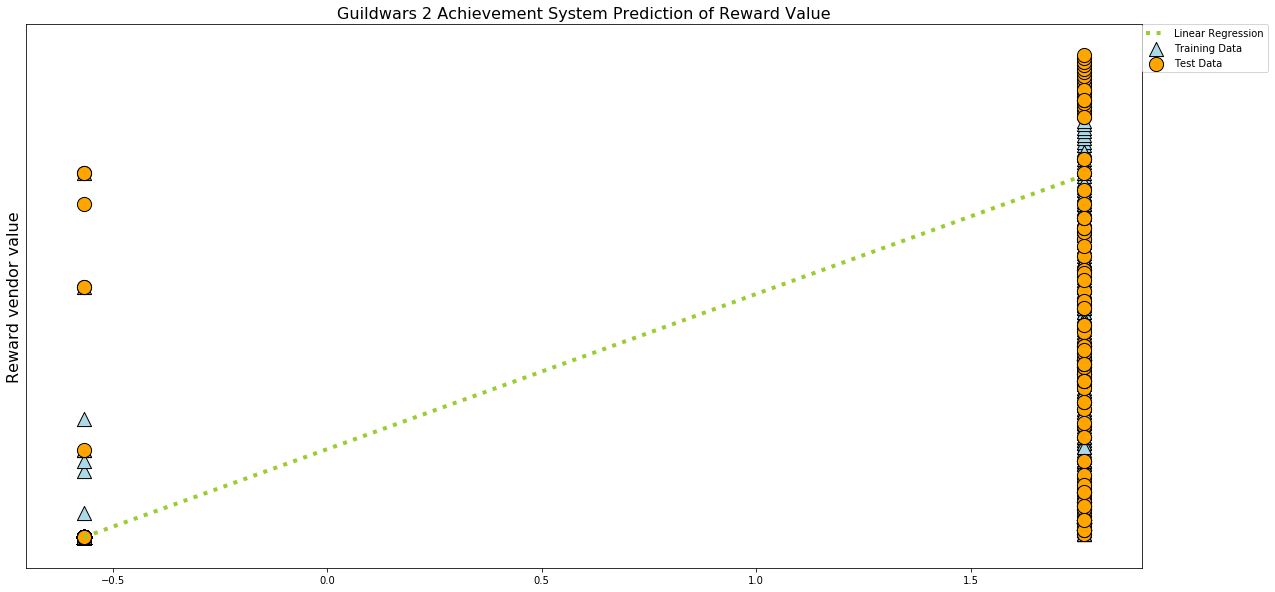

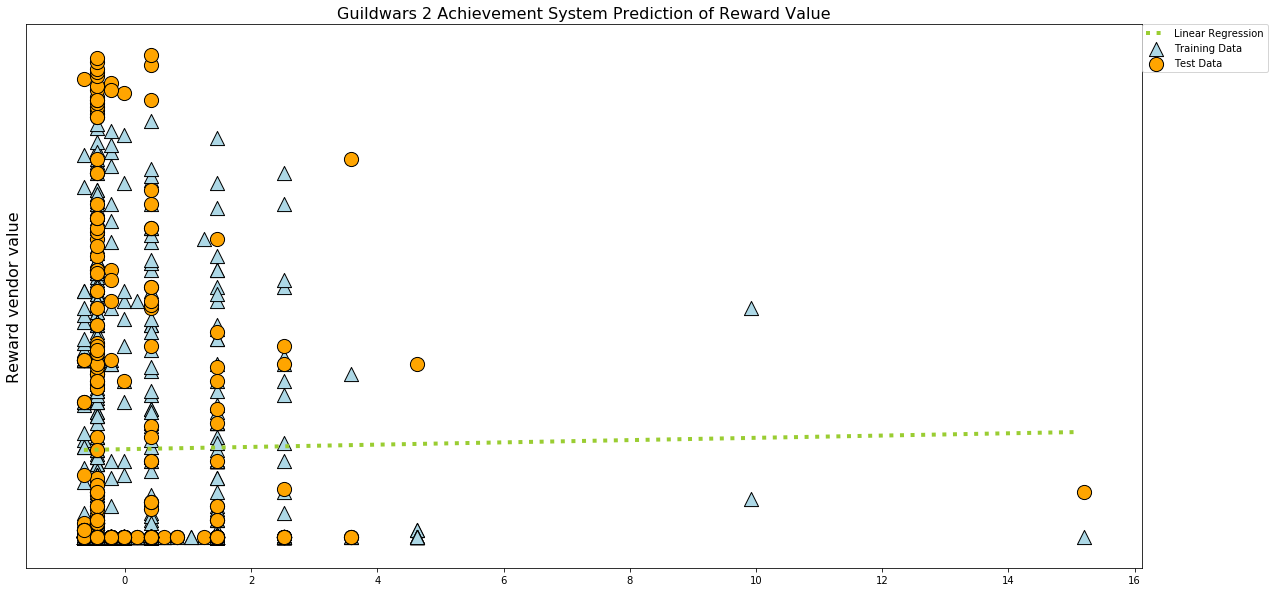

In [12]:
for i in range(5):
    plt.figure(figsize=(20,10))
    plt.title('Guildwars 2 Achievement System Prediction of Reward Value', fontsize=16)
    plt.ylabel('Reward vendor value', fontsize=16)
    bias = LinearReg.intercept_
    coefficient = LinearReg.coef_[i]
    xrange = np.arange(min(X_train[:, i]), max(X_train[:, i]), step = (max(X_train[:, i])-min(X_train[:, i]))/100)
    Y_model = coefficient*xrange + bias
    plt.scatter(X_train[:, i], y_train, s=200, marker='^', 
                edgecolor='k', color='lightblue', label = "Training Data")
    plt.scatter(X_test[:, i], y_test, s=200, marker='o', 
                edgecolor='k',color='orange', label = "Test Data")
    plt.plot(xrange, Y_model, color='yellowgreen', linewidth=4, 
             linestyle='dotted', label = "Linear Regression")
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
    plt.yticks([], [])
    #plt.savefig('reg'+str(i)+'.png')
    #plt.close()
    plt.show()

# Decision Trees Regressor

[0.4211281851772919, 0.8872990504459094, 0.9239433987521478, 0.9501680171443446, 0.9638418048252075, 0.9692253132969378, 0.9736400419341846, 0.9770088754424683, 0.9783267190069925, 0.9790609509574958, 0.9792570549923326, 0.9793688812579285, 0.9794239735723571, 0.9794445413697437]
[0.4606201768483039, 0.881471897039739, 0.9253502821489087, 0.9409963889098938, 0.9422296027325398, 0.9406202874742942, 0.9479348362441344, 0.9441948971816261, 0.9489825006320454, 0.9448352117230446, 0.9476702181925095, 0.9475136987937794, 0.9474393281845856, 0.9471752604873788]


<function matplotlib.pyplot.show(*args, **kw)>

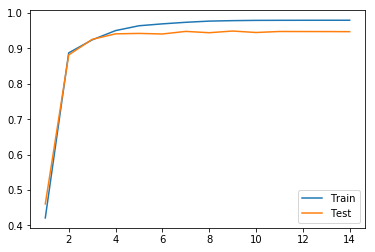

In [13]:
#using decision trees with range of depth
from sklearn import tree
train_score = []
test_score = []
depths = range(1,15)
for i in depths:
    my_tree = tree.DecisionTreeRegressor(max_depth=i)
    my_tree.fit(X_train, y_train)
    train_score.append(my_tree.score(X_train,y_train))
    test_score.append(my_tree.score(X_test,y_test))
    
print(train_score)
print(test_score)

plt.plot(depths, train_score, label = "Train")
plt.plot(depths, test_score, label = "Test")
plt.legend()
plt.show

In [14]:
DT_model = tree.DecisionTreeRegressor(max_depth=15)
DT_model.fit(X_train, y_train)

DT_model_2 = tree.DecisionTreeRegressor(max_depth=5)
DT_model_2.fit(X_train, y_train)

DT_model_3 = tree.DecisionTreeRegressor(max_depth=3)
DT_model_3.fit(X_train, y_train)

print("Training score: %3.6f" % (DT_model.score(X_train, y_train)))
print("Test score: %3.6f" % (DT_model.score(X_test, y_test)))

print("Training score: %3.6f" % (DT_model_2.score(X_train, y_train)))
print("Test score: %3.6f" % (DT_model_2.score(X_test, y_test)))


Training score: 0.979445
Test score: 0.943880
Training score: 0.963842
Test score: 0.942212


In [15]:
predictionDT = DT_model.predict(X_train)
predictionDT_2 = DT_model_2.predict(X_train)

In [16]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

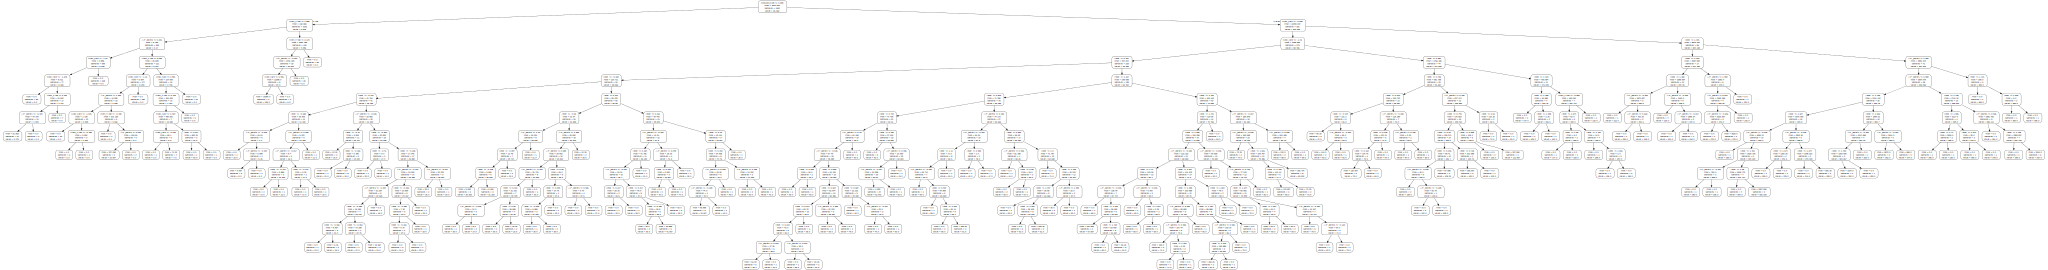

In [17]:
data_feature_names = ['How_rare','level','Item_Type','Reward_type','AP_points']
from graphviz import Source
Source(tree.export_graphviz(DT_model, out_file=None, 
                            feature_names=data_feature_names, 
                            rounded=True))

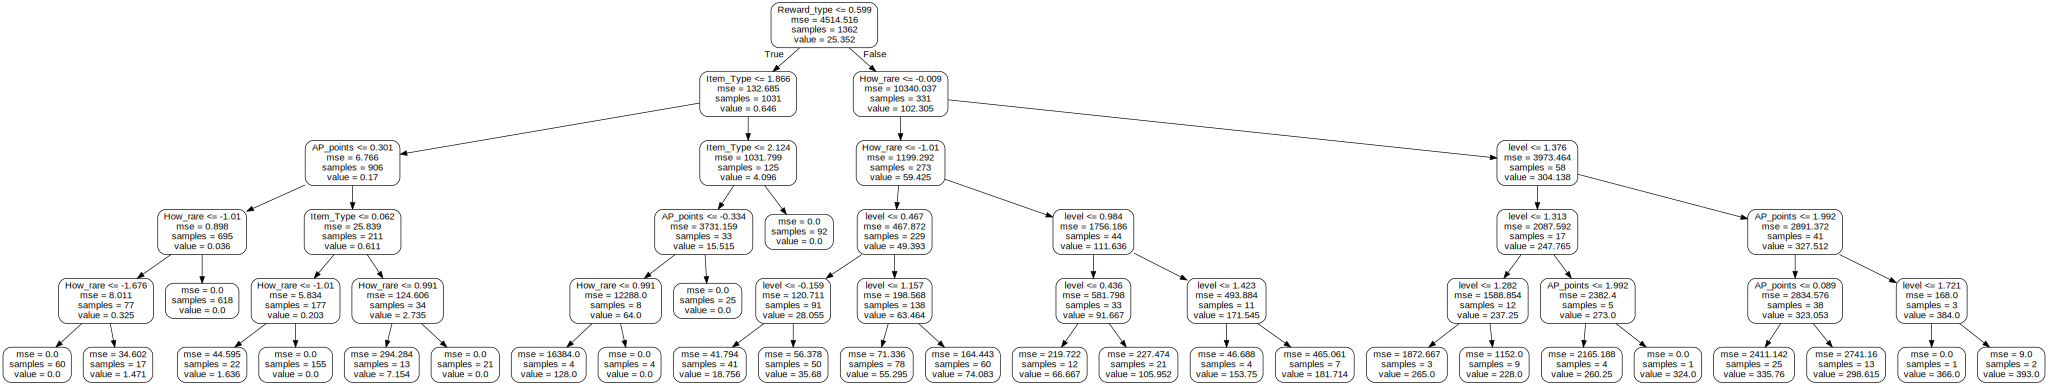

In [18]:
Source(tree.export_graphviz(DT_model_2, out_file=None, 
                            feature_names=data_feature_names, 
                            rounded=True))

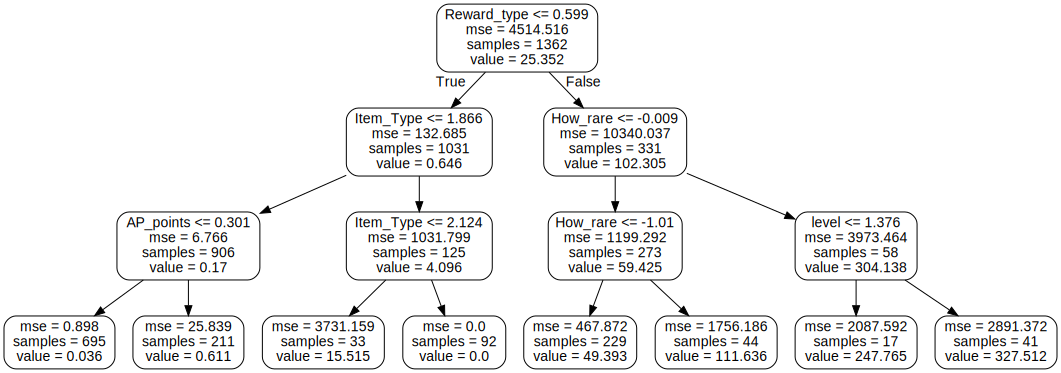

In [19]:
Source(tree.export_graphviz(DT_model_3, out_file=None, 
                            feature_names=data_feature_names, 
                            rounded=True))

Feature importances:              importance
feature                
How rare        0.50510
Reward type     0.42997
Level           0.04861
AP points       0.01445
Item Type       0.00187


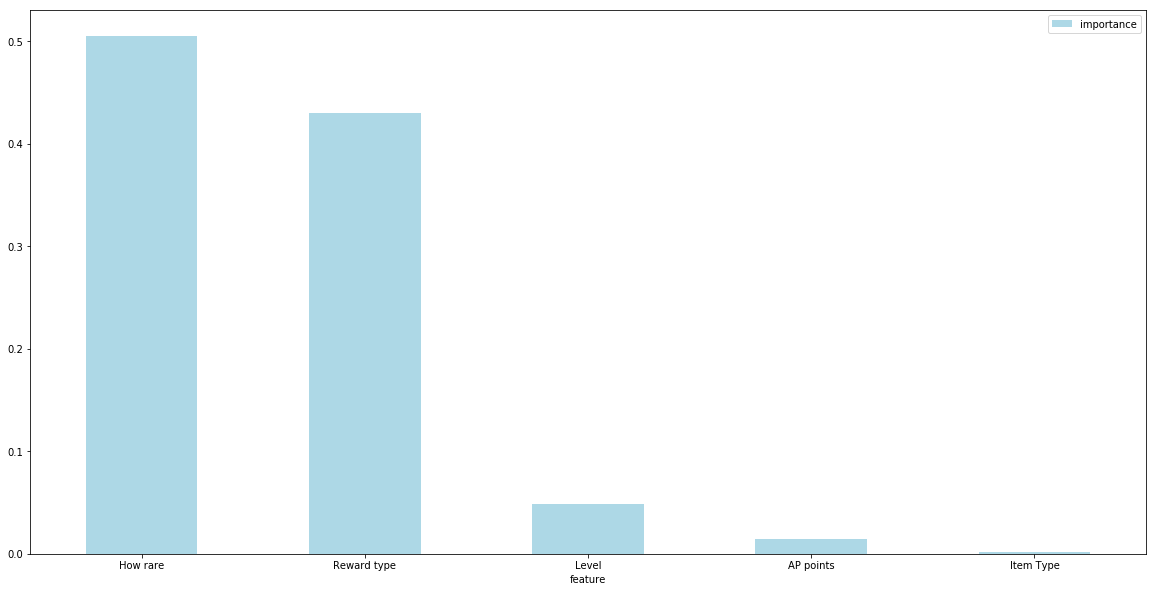

In [20]:
data_feature_names = ['How rare','Level','Item Type','Reward type','AP points']
importances = pd.DataFrame({'feature':data_feature_names,'importance':
                            np.round(DT_model.feature_importances_,5)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
 
print('Feature importances:',importances)

importancesBar = importances.plot.bar(figsize=(20,10),rot=0, 
                                      color='lightblue')

# Random Forest Classification

In [21]:
'''
in order to to classify the data- I am going to create 
a new Train/Test split which is based on the group data
'''

from sklearn.model_selection import train_test_split

X_for = Achievements_items_sorted[['How_rare','level','Reward_Type','Item_Type','AP_points','vendor_value']]
y_for = Achievements_items_sorted['Group_name']


X_train_for, X_test_for, y_train_for, y_test_for = train_test_split(X_for,y_for,test_size = 0.3,random_state = 0)

scaler = StandardScaler()
scaler.fit(X_train_for)
X_train = scaler.transform(X_train_for)
X_test = scaler.transform(X_test_for)

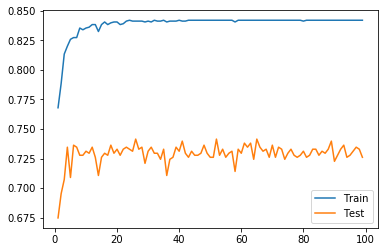

In [22]:
from sklearn.ensemble import RandomForestClassifier
list_est = range(1,100)
n_estimators = []
train_score_for = []
test_score_for = []
for k in list_est:
    rf_model = RandomForestClassifier(n_estimators = k).fit(X_train_for, y_train_for)
    train_score_for.append(rf_model.score(X_train_for, y_train_for))
    test_score_for.append(rf_model.score(X_test_for, y_test_for))

    
plt.plot(list_est, train_score_for, label = "Train")
plt.plot(list_est, test_score_for, label = "Test")
plt.legend()
plt.show()

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

random_forrest_for = RandomForestClassifier(n_estimators=100)
random_forrest_for.fit(X_train_for, y_train_for)
print("The classification accuracy of model is: %3.3f" % (random_forrest_for.score( X_train_for, y_train_for)))
print("The classification accuracy of model is: %3.3f" % (random_forrest_for.score( X_test_for, y_test_for)))

The classification accuracy of model is: 0.842
The classification accuracy of model is: 0.736


In [24]:
predictions_for = random_forrest_for.predict(X_test_for)

print("Accuracy:",metrics.accuracy_score(y_test_for, predictions_for))

pd.crosstab(y_test_for, predictions_for, rownames=['predicted label'], colnames=['true label'])

Accuracy: 0.7363013698630136


true label,Collections,Competitive,Daily,Fractals of the Mists,General,Heart of Thorns,Path of Fire,Raids,Side Stories,Story Journal
predicted label,,,,,,,,,,
Collections,204,0,2,5,1,1,0,5,0,16
Competitive,1,3,0,0,0,0,0,0,0,0
Daily,0,0,24,0,0,0,1,0,0,1
Fractals of the Mists,0,0,4,13,1,0,0,0,0,6
General,1,0,0,1,21,0,0,1,0,11
Heart of Thorns,0,0,0,0,0,20,3,0,0,9
Path of Fire,5,0,0,1,0,6,37,0,0,12
Raids,0,0,0,0,0,0,0,6,0,1
Side Stories,3,0,0,0,0,1,0,0,4,15


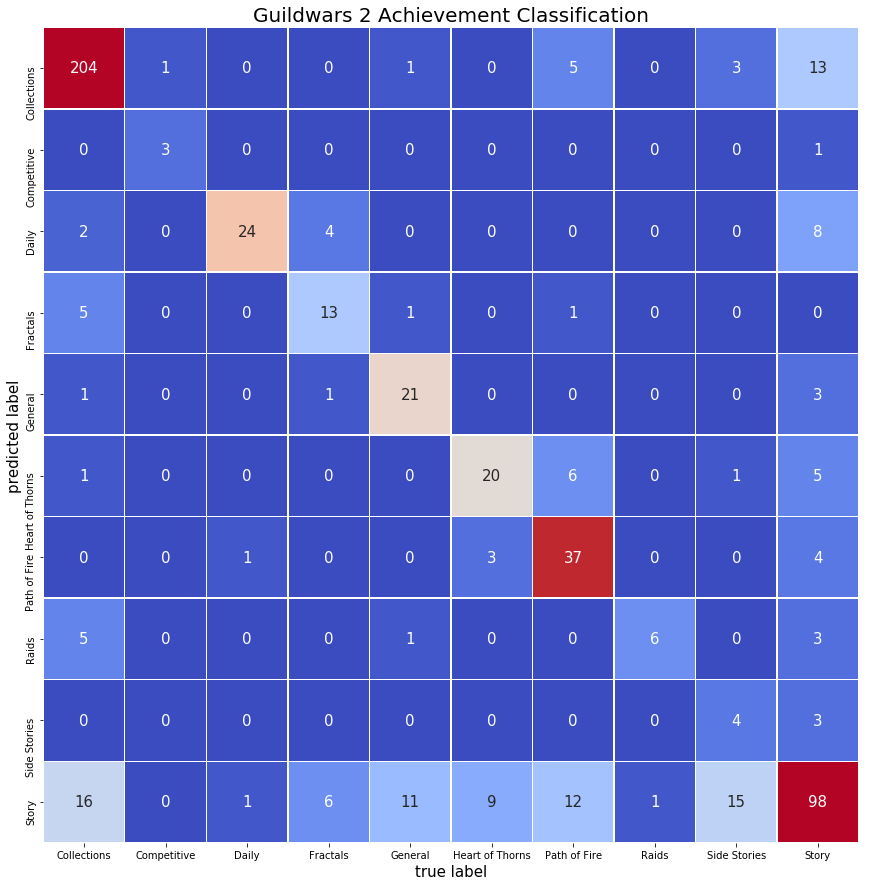

In [25]:
mat = confusion_matrix(y_test_for, predictions_for)
plt.figure(figsize=(15,15))
plt.title('Guildwars 2 Achievement Classification', fontsize=20)

Heatmap = sns.heatmap(mat.T, square=True, annot=True, fmt='d', linewidths=.5, 
            cmap="coolwarm", cbar=False, annot_kws={"size":15}, 
            robust=True)

labels=['Collections','Competitive','Daily','Fractals','General',
       'Heart of Thorns','Path of Fire','Raids','Side Stories','Story']
Heatmap.set_yticklabels(labels)
Heatmap.set_xticklabels(labels)
plt.xlabel('true label', fontsize=15)
plt.ylabel('predicted label', fontsize=15);

In [26]:
from sklearn import metrics
print(metrics.classification_report(y_test_for, predictions_for))

                       precision    recall  f1-score   support

          Collections       0.90      0.87      0.89       234
          Competitive       0.75      0.75      0.75         4
                Daily       0.63      0.92      0.75        26
Fractals of the Mists       0.65      0.54      0.59        24
              General       0.81      0.60      0.69        35
      Heart of Thorns       0.61      0.62      0.62        32
         Path of Fire       0.82      0.61      0.70        61
                Raids       0.40      0.86      0.55         7
         Side Stories       0.57      0.17      0.27        23
        Story Journal       0.58      0.71      0.64       138

          avg / total       0.75      0.74      0.73       584



Feature importances:               importance
feature                 
AP points        0.29527
Item Type        0.18928
How rare         0.17767
Vendor Value     0.16140
Level            0.13801
Reward type      0.03837


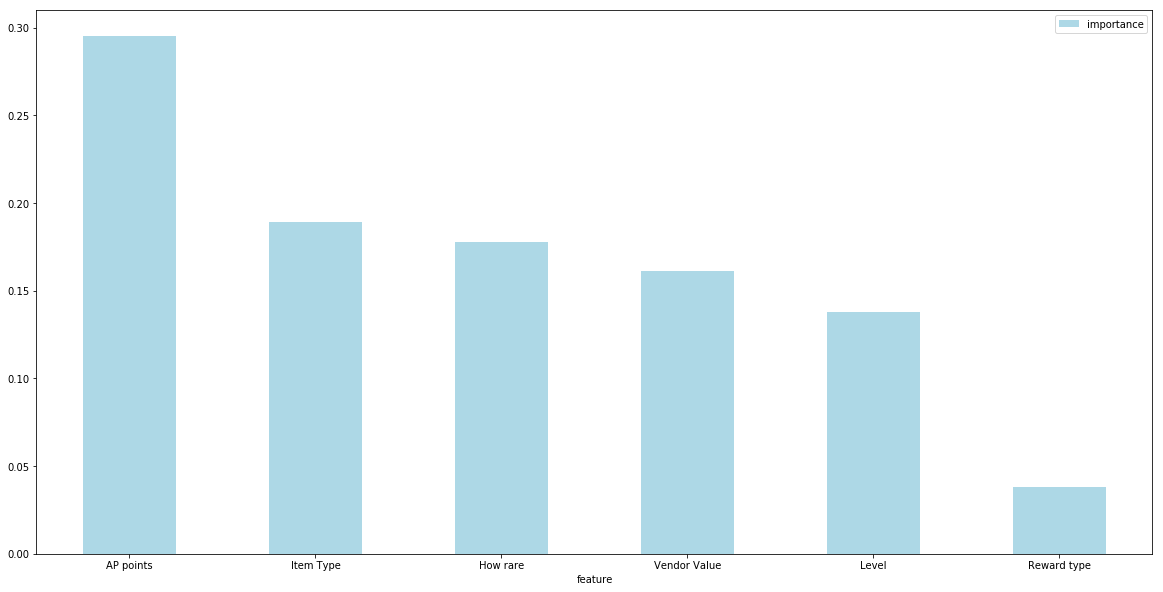

In [27]:
data_feature_name = ['How rare','Level','Item Type','Reward type','AP points','Vendor Value']
importances_for = pd.DataFrame({'feature':data_feature_name,'importance':
                            np.round(random_forrest_for.feature_importances_,5)})
importances_for = importances_for.sort_values('importance',ascending=False).set_index('feature')
 
print('Feature importances:',importances_for)

importancesBar_for = importances_for.plot.bar(figsize=(20,10),rot=0, 
                                      color='lightblue')